# Kings County Housing Prices Model

Below are the steps taken to generate a model that can predict the price of a house selling in the Kings County, Washington real-estate market

## Set up

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle

from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV
from sklearn.linear_model import Lasso, Ridge

# style seaborn
sns.set(style="darkgrid")
# allow pandas to display more data than the default
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
# import training data
df = pd.read_csv("provided_data/kc_house_data_train.csv", index_col="Unnamed: 0")

In [3]:
# EDA with numeric variables
ignore_cols = ['id', 'price', 'date']
explore_cols = [x for x in df.columns if x not in ignore_cols]

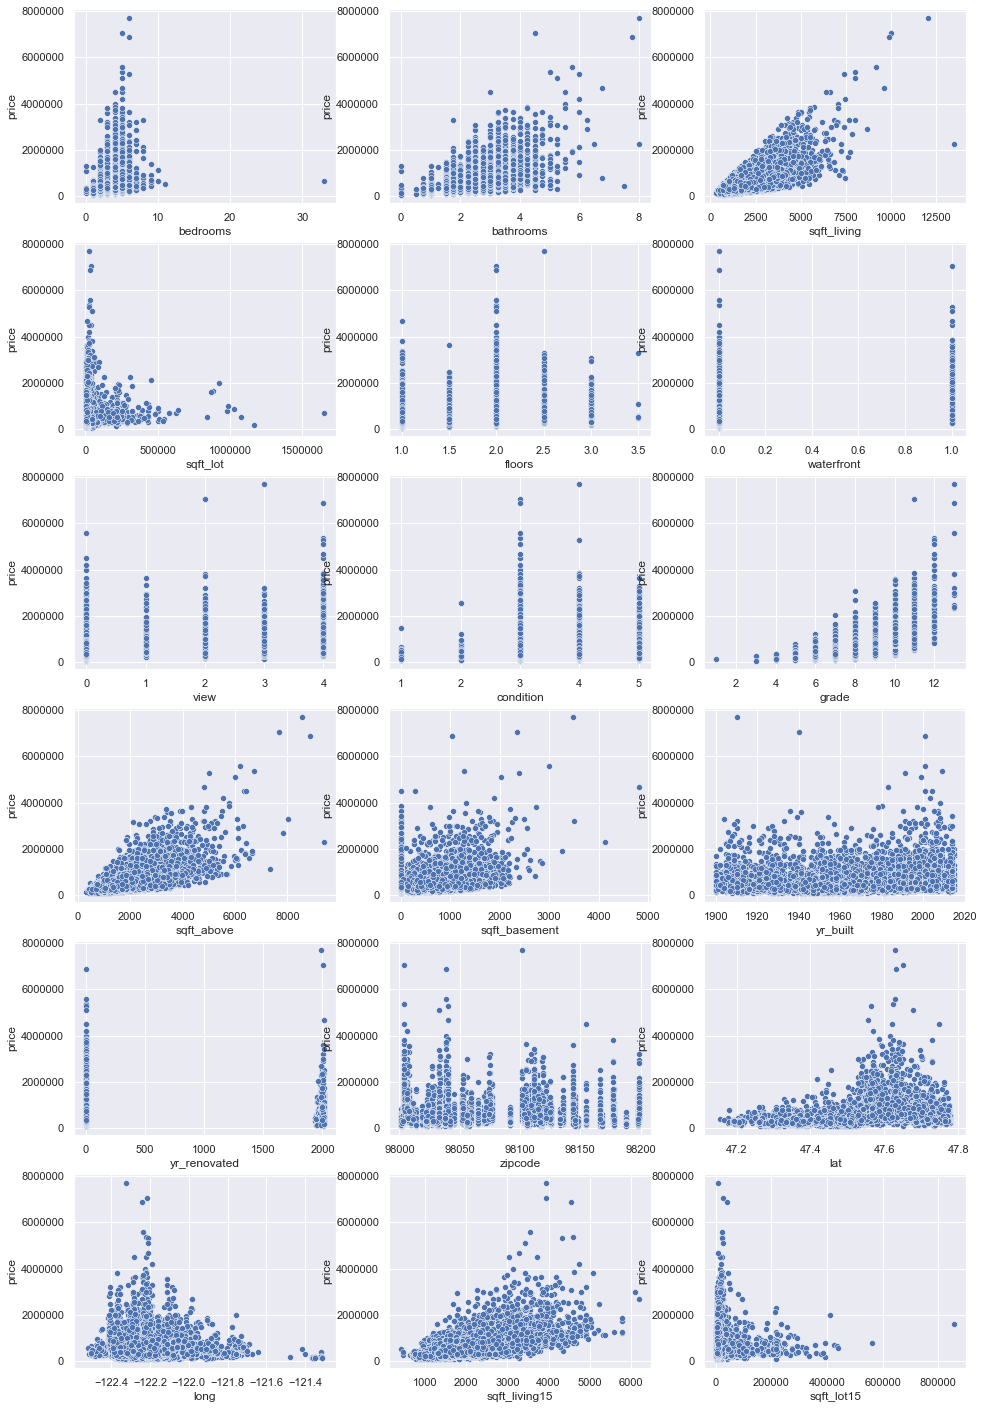

In [4]:
# plot numeric variables with housing prices to check for clear relationships
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,25))

for i, column in enumerate(explore_cols):
    sns.scatterplot(data = df, x=column,y='price', ax=axes[i//3, i%3])

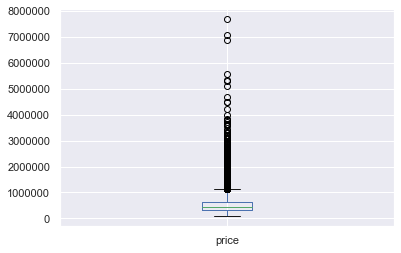

In [5]:
#check distribution of target variable
df.price.plot.box();

In [6]:
# format date column to datetime
df['date'] = pd.to_datetime(df['date'], format="%Y%m%dT000000")

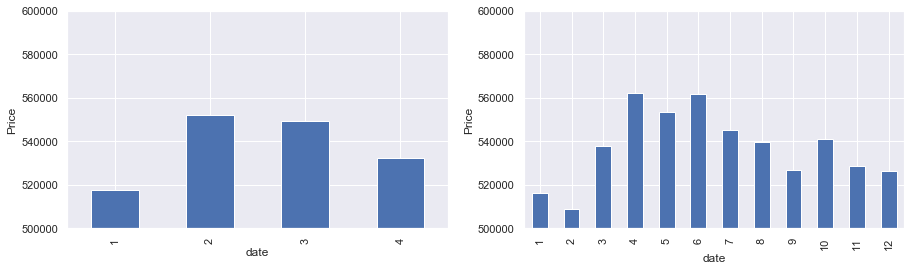

In [7]:
# check for seasonal trends
fig = plt.figure(figsize=(15,4))
df.groupby((df.date.dt.month%12 + 3)//3)['price'].mean().plot(kind='bar', ax=fig.add_subplot(121))
plt.ylim(500000,600000)
plt.ylabel('Price')
plt.title("");

# this was inspired by GitHub user SlimHintz.
df.groupby(df.date.dt.month)['price'].mean().plot(kind='bar', ax=fig.add_subplot(122))
plt.ylim(500000,600000)
plt.ylabel('Price')
plt.title("");

In [8]:
# Corrected data on outlier data using real estate website
df['bedrooms'] = df['bedrooms'].replace({11:4, 33:3})

## Generate new features

In [9]:
# feature for whether a house is a small building on a large plot of land
df['shack_living'] = np.where(df['sqft_living']/df['sqft_lot'] < .2, 1, 0)

In [10]:
# calculates how old the building is 
df['yrs_old'] = 2020-df.yr_built

### Age of house feature

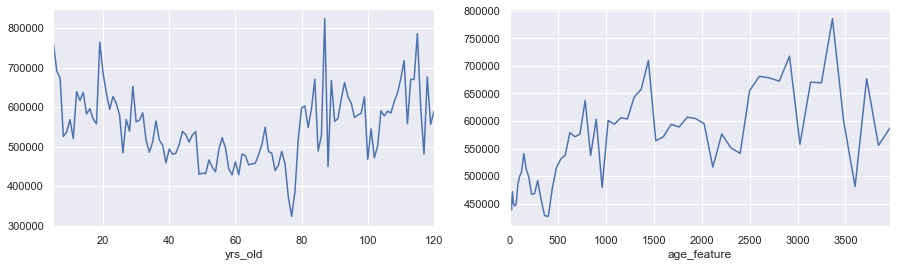

In [11]:
# graph to see shape of building age to price distribution
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
df.groupby(['yrs_old'])['price'].mean().plot(ax=ax1)

# coerce shape of age to a linear one
df['age_feature'] = (df['yrs_old'] - 57)**2
# visualize new feature
ax2 = fig.add_subplot(122)
df.groupby(['age_feature'])['price'].mean().plot(ax=ax2);

### House quality feature

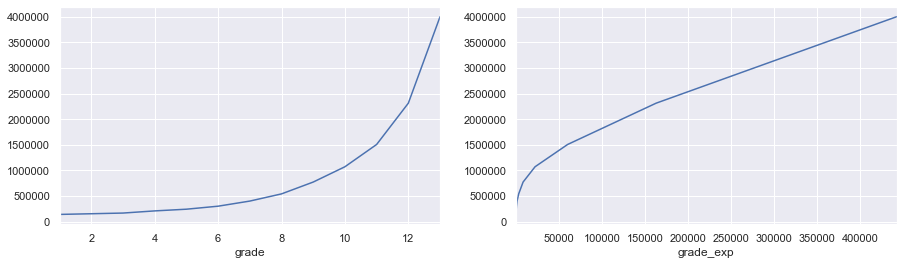

In [12]:
# show trend of grade and price relationship
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
df.groupby(['grade'])['price'].mean().plot(x=ax1);

# transform to a linear shape
df['grade_exp'] = np.exp(df['grade'])
# visualize new feature
ax2 = fig.add_subplot(122)
df.groupby(['grade_exp'])['price'].mean().plot(ax=ax2);

### Condition feature

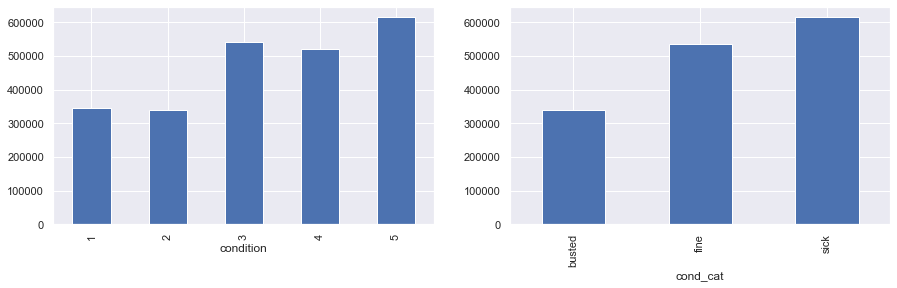

In [13]:
# visualize condition trend
fig = plt.figure(figsize=(15,4))
df.groupby(['condition'])['price'].mean().plot(kind='bar', ax=fig.add_subplot(121))

# feature to group condition of houses
conditions = [df['condition']<= 2, df['condition'].isin(range(3, 5)), df['condition'] == 5]
choices = ['busted', 'fine', 'sick']

df['cond_cat'] = np.select(conditions, choices, default = 'missing')

# plot new feature
df.groupby(['cond_cat'])['price'].mean().plot(kind='bar', ax=fig.add_subplot(122));

### Basement feature

In [14]:
# feature to account for whether the house has a basement
# this includes data about basement square-footage without 
# running into multi-colinearity with sqftage in general
df['has_basement'] = np.where(df['sqft_basement'] == 0, 0, 1)

### Season feature

In [15]:
# group each housing sale into seasons
df['season'] = (df.date.dt.month%12 + 3)//3

## Create dummy variables from categorical features 

In [16]:
season_dum = pd.get_dummies(df['season'], prefix='sn', drop_first=True)
zipcode_dum = pd.get_dummies(df['zipcode'], prefix='zp', drop_first=True)
cond_dum = pd.get_dummies(df['cond_cat'], prefix='condtn', drop_first=True)
# concatenate dummies with dataframe
df = pd.concat([df, cond_dum, zipcode_dum, season_dum], 1)

## Prepare for modeling

In [17]:
# create a feature subset by selecting columns to exclude
leave_out = ['id', 'date', 'season', 'price', 'cond_cat', 'sqft_lot', 
             'floors', 'view', 'condition', 'grade', 'sqft_above', 
             'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 
             'yrs_old','long', 'sqft_living15']
features = [x for x in df.columns if x not in leave_out] 

In [18]:
# check for multicolinearity
features_check = [x for x in features if "zp" not in x]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[features_check].values, i) for i in range(df[features_check].shape[1])]
vif["features"] = df[features_check].columns
vif.round(1)

,VIF Factor,features
0,23.5,bedrooms
1,21.7,bathrooms
2,21.8,sqft_living
3,1.0,waterfront
4,1.5,sqft_lot15
5,2.2,shack_living
6,2.5,age_feature
7,1.7,grade_exp
8,1.9,has_basement
9,21.0,condtn_fine


### Create polynomial features

In [19]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
# fit features to dataset
poly2_data = poly_2.fit_transform(df[features])
# set columns for dataframe
poly2_columns = poly_2.get_feature_names(df[features].columns)
# create pandas dataframe with polynomial data and columns
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)

In [77]:
# train-test split polynomial data
X_train, X_test, y_train, y_test = train_test_split(df_poly2, df['price'], random_state=27,test_size=0.2)

In [78]:
# scale polynomial data
scaler2 = StandardScaler()

scaler2.fit(X_train)

X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_poly2.columns)

X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_poly2.columns)

## Recursive Feature Selection

In [79]:
# instantiate Lasso class object
lasso = Lasso(alpha=800, normalize=False)
# fit polynomial data set to lasso model
lasso.fit(X_train,y_train)
# create predictions using Lasso
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
# check for model accuracy
train_rmse_lasso = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_lasso))
print('Testing Error: '+ str(test_rmse_lasso))

Training Error: 119743.40525650613
Testing Error: 139642.96078269606


In [80]:
# check coefficient of determination of model (R-Squared)
print(f"R-Squared of Model: {lasso.score(X_test, y_test)}")

R-Squared of Model: 0.8551471514336239


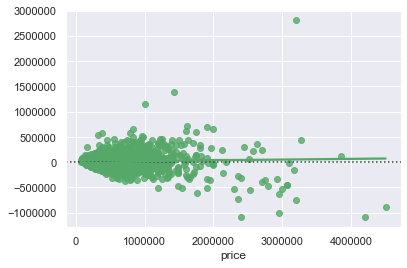

In [81]:
# graph residuals
sns.residplot(x = y_test, y= y_pred, lowess=True, color = "g");

# Refit model to the entire dataset

In [82]:
# instantiate new scaler object
final_scaler = StandardScaler()
# fit full dataset to scaler
df_final_scaled = pd.DataFrame(data=final_scaler.fit_transform(df_poly2), columns=poly2_columns)

In [83]:
# instantiate new Lasso object
lasso_final = Lasso(alpha=800, normalize=False)
# fit Lasso model object to dataframe
lasso_final.fit(df_final_scaled, df['price'])

Lasso(alpha=800, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## Save final model and scaler with pickle

In [84]:
# pickle model
pickle_out = open("pickle_jar/model.pkl", "wb")
pickle.dump(lasso_final, pickle_out)
pickle_out.close()

In [85]:
# pickle scaler
pickle_out = open("pickle_jar/scaler.pkl", "wb")
pickle.dump(final_scaler, pickle_out)
pickle_out.close()